In [4]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.animation as animation

m=gp.Model("VRPSDP22")

# Number of nodes
N=22 

# Number of cars
K=5

# Capacity of each car
C=6000

# Create xij index
x = m.addVars(N, N, vtype=GRB.BINARY, name='x')

d=np.zeros((N, N))

# Nodes coordinates and distances between them
Nodes = np.array([(145,215),
(151,264),
(159,261),
(130,254),
(128,252),
(163,247),
(146,246),
(161,242),
(142,239),
(163,236),
(148,232),
(128,231),
(156,217),
(129,214),
(146,208),
(164,208),
(141,206),
(147,193),
(164,193),
(129,189),
(155,185),
(139,182)
])
for i in range(N):
    for j in range(N):
        d[i][j]=np.linalg.norm([Nodes[i][0]-Nodes[j][0], Nodes[i][1]-Nodes[j][1]])

# Delivery demand
quantity = np.array([0,1100,700,800,1400,2100,400,800,100,500,600,1200,1300,1300,300,900,2100,1000,900,2500,1800,700])

# Pickup demand
backhaul = np.array([0,700,1100,700,800,1400,2100,400,800,100,500,600,1200,1300,1300,300,900,2100,1000,900,2500,1800])

# Create Rij index;
R=m.addVars(N, N, vtype=GRB.INTEGER, name='R')

# Create Pij index;
P=m.addVars(N, N, vtype=GRB.INTEGER, name='P')

# Objective function√
m.setObjective(sum(d[i][j]*x[i,j] for i in range(N) for j in range(N)),GRB.MINIMIZE)

# Add Constraints
# Summation of Xij  =1,  where j is from 0 to N, for all i;√
m.addConstrs((sum(x[i,j] for i in range(N)) == 1 for j in range(1,N)), name='E1')

# Summation of Xij  =1,  where i is from 0 to N, for all j;√
m.addConstrs((sum(x[j,i] for i in range(N)) == 1 for j in range(1,N)), name='E2')

# Summation Rij -qj= Summation Rji
m.addConstrs(((((sum(R[i,j] for i in range(N)))-quantity[j])==(sum(R[j,i] for i in range(N)))) for j in range(1,N)), name='E3')

# Summation Pij +bj= Summation Pji
m.addConstrs((((sum(P[i,j] for i in range(N))+backhaul[j])==(sum(P[j,i] for i in range(N)))) for j in range(1,N)), name='E4')

# Summation Ri0=0
m.addConstrs(((sum(R[i,0] for i in range(1,N))==0) for j in [0]), name='E5')

# Summation P0j=0
m.addConstrs(((sum(P[0,j] for j in range(1,N))==0) for i in [0]), name='E6')

# Rij+Pij<=Cxij
m.addConstrs((((R[i,j]+P[i,j])<=C*x[i,j]) for i in range(N) for j in range(N)),name='E7')

# Rij>=0
m.addConstrs(((R[i,j]>=0) for i in range(N) for j in range(N)),name='E8')

# Pij>=0
m.addConstrs(((P[i,j]>=0) for i in range(N) for j in range(N)),name='E9') 

# Vehicles
m.addConstrs((sum(x[0,i] for i in range(1,N))==K for j in [0]) ,name='E10')

{0: <gurobi.Constr *Awaiting Model Update*>}

In [5]:
m.optimize()

if m.status == GRB.INFEASIBLE:
    m.computeIIS()
    print('\nThe following constraints and variables are in the IIS:')
    for c in m.getConstrs():
        if c.IISConstr:
            print(f'\t{c.constrname}: {m.getRow(c)} {c.Sense} {c.RHS}')

    for v in m.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')

print(f'Optimal Total Distance is {m.ObjVal}')

# Retrieve the optimal route
optimal_route = [(i,j) for i in range(N) for j in range(N) if x[i,j].x > 0.5]

# Sort the optimal route
start_location = 0  # assuming the route starts at location 0
sorted_route = []
while optimal_route:
    for i, route in enumerate(optimal_route):
        if route[0] == start_location:
            start_location = route[1]
            sorted_route.append(route)
            optimal_route.pop(i)
            break

# Create an array of locations in the sorted route
route_array = [route[0] for route in sorted_route]
route_array.append(sorted_route[-1][1])  # add the final location
route_array.pop(0)
print(route_array)

# Split the route array into separate routes
routes = []
current_route = []
for i, location in enumerate(route_array):
    current_route.append(location)
    if location == start_location and i != 0:
        routes.append(current_route)
        current_route = []

# Add the last route
if current_route:
    routes.append(current_route)

# Prepend the start location to each route
for i, route in enumerate(routes):
    if i > 0:
        route.insert(0, start_location)

# Print the routes
for i, route in enumerate(routes):
    print(f"Route {i+1}:")
    print(route)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1539 rows, 1452 columns and 5171 nonzeros
Model fingerprint: 0x7747dc1b
Variable types: 0 continuous, 1452 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [3e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 1013 rows and 129 columns
Presolve time: 0.02s
Presolved: 526 rows, 1323 columns, 3927 nonzeros
Variable types: 0 continuous, 1323 integer (441 binary)

Root relaxation: objective 3.301056e+02, 1168 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  330.10559    0   42          -  330.10559    

C:\Users\jorge\AppData\Local\Temp\ipykernel_24004\11696687.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  dot, = plt.plot([], [], 'ro', color='red')
C:\Users\jorge\AppData\Local\Temp\ipykernel_24004\11696687.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  route_plots = [plt.plot([], [], 'b-', color='black')[0] for _ in routes]
C:\Users\jorge\AppData\Local\Temp\ipykernel_24004\11696687.py:37: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(Nodes[position])


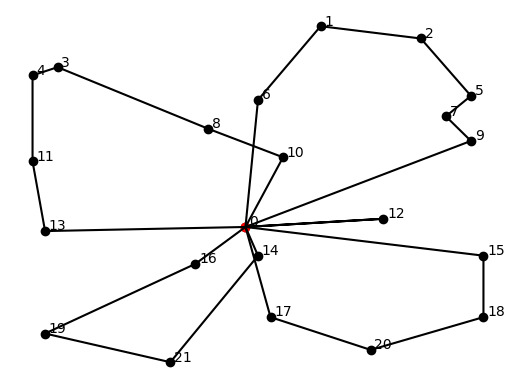

In [6]:
plt.gcf().set_facecolor('white')
plt.gca().set_facecolor('white')

# Create a scatter plot of the nodes
plt.scatter(Nodes[:,0], Nodes[:,1], color='black')

# Label the nodes
for i, node in enumerate(Nodes):
    plt.text(node[0] + 0.3, node[1] + 0.3, str(i), color='black')

# Hide the labels on the x and y axis
plt.xticks([])
plt.yticks([])

# Remove the canvas border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Create a plot for the dot with color
dot, = plt.plot([], [], 'ro', color='red')

# Create a plot for each route with white lines
route_plots = [plt.plot([], [], 'b-', color='black')[0] for _ in routes]

def animate(i):
    # Calculate the current route and position
    route_index = i // len(Nodes)
    position_index = i % len(Nodes)
    
    # Get the current route and position
    route = routes[route_index]
    position = route[position_index % len(route)]
    
    # Update the position of the dot
    dot.set_data(Nodes[position])
    
    # Update the route plot
    route_plots[route_index].set_data(Nodes[route].T)

# Create an animation
ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(routes)*len(Nodes), interval=200)

# Save the animation
ani.save('animation.gif', writer='pillow')